In [1]:
# ------------------------- IMPORTS -------------------------
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import random
import skimage.io as io
from skimage.color import rgb2gray
import cv2
import os

In [3]:
# ------------------------------ GET CURRENT PATH ------------------------------
dirname = os.path.abspath(os.getcwd())
dataset_path = os.path.join(dirname, 'Datasets')
test_images_path = os.path.join(dirname, 'Test Images')
training_result_path = os.path.join(dirname, 'Training Result Data')
omegas_path = os.path.join(training_result_path, 'omegas.npy')
average_image_path = os.path.join(training_result_path, 'average_image.npy')
eigenfaces_path = os.path.join(training_result_path, 'eigenfaces.npy')


In [4]:
# ---------------------------- LOAD OLIVETTI DATASET ---------------------------- #

def load_olivetti_dataset():
    dataset = fetch_olivetti_faces(data_home=dataset_path, shuffle=True)
    return dataset

In [ ]:
def load_our_dataset():
    pass
    

In [5]:
#  ---------------------------- CONVERT IMAGE TO GRAY SCALE AND SAME SHAPE OF TRAINED IMAGES ---------------------------- #

def convert_image(image, width, height):
    plt.imshow(image, cmap='gray', label='Input image')
    plt.show()
    # if image is RGB, convert to grayscale
    if len(image.shape) > 2:
        image = rgb2gray(image)
    # resize image to width*height
    image = cv2.resize(image, (width, height))
    if (np.max(image) > 1):
        image = image / 255.0
    image = image.reshape((width*height, 1))
    # Show image
    plt.imshow(image.reshape(height, width), cmap='gray', label='Input image')
    plt.show()

    return image

In [6]:
# ---------------------------- EXTRACT INFO FROM DATASET ---------------------------- #

def extract_info_from_dataset(dataset, verbose=False):
    '''
    Returns: 
        - images: ndarray(m, height, width): the images of the dataset
        - m: int: the number of images in the dataset
        - height: int: the height of each image
        - width: int: the width of each image
        - total_images: int:  the total number of images in the dataset
        - n_features: int: the number of features of each image = height * width
        - y: ndarray(m,): the labels of the images
        - num_people: int the number of people in the dataset
    '''

    images = dataset.images

    m = images.shape[0]
    if(verbose):
        print('Images shape:', images.shape)

    total_images, height, width = images.shape
    if(verbose):
        print(f'Each image has size: {height} x {width}')
        print(70 * '-')

    n_features = height*width
    if(verbose):
        print(f'N^2 = n_features = h x w = {n_features}')
        print(70 * '-')

    y = dataset.target
    if(verbose):
        print('y has shape:', y.shape)

    num_people = np.max(y) + 1
    if(verbose):
        print('Number of people =', num_people)

    return images, m, height, width, total_images, n_features, y, num_people


In [7]:
#----------------------- CREATE PEOPLE DICTIONARY -----------------------#


def create_people_dict(total_images, num_people, y):
    # Key: person ID
    # Value: List of all person images indices
    person_image_dict = dict()

    for image_index in range(total_images):
        if (y[image_index] not in person_image_dict.keys()):
            person_image_dict[y[image_index]] = [image_index]
        else:
            person_image_dict[y[image_index]].append(image_index)
    return person_image_dict


In [8]:
# ------------------ VIEW RANDOM IMAGE ------------------ #

def view_rand_image(images, m):
    index = int(random.random() * m)
    index = 0
    image = images[index, :, :]
    # name = target_names[y[index]]

    # print(name)
    plt.imshow(image, cmap='gray')
    plt.show()


In [9]:
# --------------------- GET FLATTEN IMAGES --------------------- #

def get_flattened_images(images, m, height, width, verbose=False):
    # Flatten images array
    # Each column is an image

    # N^2 * M
    flattened_images = images.reshape(m, -1).T

    if(verbose):
        print(
            f'Shape of training images after flattening: {flattened_images.shape}')

    return flattened_images


In [10]:
# ----------------- CALCULATE AVERAGE IMAGE ----------------- #

def get_average_image(flattened_images, height, width, verbose=False):
    # In all corresponding pixels in all images, we calculate the average

    # N^2 * 1
    average_image = np.mean(flattened_images, axis=1)[:, np.newaxis]
    if(verbose):
        print(f'Average image has shape: {average_image.shape}')
        plt.imshow(average_image.reshape(height, width),
                   cmap='gray', title='Average Image')
        plt.show()
    return average_image


In [11]:
#-------------------------------- GET DIFFERENCE IMAGES --------------------------------#

def get_difference_images(flattened_images, average_image, verbose=False):
    # Subtract the average image from all images
    # This is done to remove the average face from all images
    # N^2 * M
    difference_images = flattened_images - average_image
    if(verbose):
        print(
            f'Shape after subtracting average face: {difference_images.shape}')
    return difference_images



In [12]:
# --------------------- SHOW ONE DIFFERENCE IMAGE AND COMPARE TO ORIGINAL --------------------- #

def show_difference_image(difference_images, train_images, height, width, m):
    # Show one difference image and compare to original
    index = int(random.random() * m)

    plt.imshow(difference_images[:, index].reshape(height, width), cmap='gray')
    plt.show()

    # Print original image
    plt.imshow(train_images[index, :, :], cmap='gray')
    plt.show()

In [13]:
#--------------------- GET COVARIANCE MATRIX --------------------- #

def get_covariance_matrix(m, n_features, difference_images, verbose=False):
    # C = A * A^T where A = difference_images
    # N^2 * M
    A = difference_images

    if (m > n_features):
        # N^2 * N^2
        covariance_matrix = np.matmul(difference_images, difference_images.T)
        if(verbose):
            print('Shape of covariance matrix = N^2 * N^2 = ',
                  covariance_matrix.shape)
        return covariance_matrix

    else:
        # M * M
        covariance_matrix = np.matmul(difference_images.T, difference_images)
        if(verbose):
            print('Shape of covariance matrix = M * M = ',
                  covariance_matrix.shape)
        return covariance_matrix


In [14]:
# --------------------------------- GET EIGENVALUES AND EIGENVECTORS --------------------------------- #

def eigenvalues_eigenfaces(covariance_matrix, difference_images, verbose=False):
    # M eigenvalues and M eigenvectors
    # where M is the number of examples

    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    if(verbose):
        print('Shape of eigenvalues:', eigenvalues.shape)
        print('Shape of eigenvectors before matrix multiplication:',
              eigenvectors.shape)

    # Try to remove
    eigenfaces = np.matmul(difference_images, eigenvectors)

    if(verbose):
        print('Shape of eigenfaces after matrix multiplication:', eigenfaces.shape)

    return eigenvalues, eigenfaces



In [15]:
# --------------------------------- NORMALIZE eigenfaces --------------------------------- #

def normalize_eigenfaces(eigenfaces, verbose=False):
    eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)
    if(verbose):
        print('Shape of eigenfaces after normalization:', eigenfaces.shape)
    return eigenfaces

In [16]:
# ------------------------ SORT eigenfaces ------------------------ #

def sort_eigenvalues_eigenfaces(eigenvalues, eigenfaces):
    # Get top K eigenfaces
    indices_of_top_eigenvalues = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[indices_of_top_eigenvalues]
    eigenfaces = eigenfaces[:, indices_of_top_eigenvalues]
    return eigenvalues, eigenfaces

In [17]:
# --------------------------------- CALCULATE K --------------------------------- #

def calculate_K(eigenvalues, m, variance=0.8, verbose=False):
    # Calculate the number of components to preserve specified variance
    K = m
    for ii, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eigen_value_cumsum > variance:
            K = ii
            break

    if(verbose):
        print(
            f'Number of components to preserve {variance*100}% of the variance = {K}')


In [18]:
# --------------------------------- SELECT K TOP eigenfaces --------------------------------- #

def select_K_top_eigenfaces(eigenvalues, eigenfaces, K, verbose=False):
    # Select only K eigenfaces
    eigenvalues = eigenvalues[:K].copy()
    eigenfaces = eigenfaces[:, :K].copy()

    if(verbose):
        print('Shape of eigenvalues after selecting top K:', eigenvalues.shape)
        # N^2 * K
        print('Shape of eigenfaces after selecting top K:', eigenfaces.shape)
    return eigenvalues, eigenfaces

In [19]:
# ------------------------ SHOW EIGENFACES ------------------------ #

def show_eigenfaces(eigenfaces, height, width, K, num_show=16):
    # Show eigenfaces
    for i in range(min(K, num_show)):
        plt.subplot(4, 4, i+1)
        plt.imshow(eigenfaces[:, i].reshape(height, width), cmap='gray')
        plt.title(f'Eigenface {i+1}')
        plt.axis('off')

In [20]:
# ------------------------ SHOW A RANDOM EIGENFACE ------------------------ #

def show_random_eigenface(eigenfaces, height, width, m):
    index = int(random.random() * m)
    plt.imshow(eigenfaces[:, index].reshape(height, width), cmap='gray')
    plt.show()

In [21]:
# ------------------------ CALCULATE OMEGAS ------------------------ #

def get_omegas(difference_images, eigenfaces, verbose=False):
    omegas = []
    for image in difference_images.T:
        omegas.append(np.dot(image, eigenfaces))
    omegas = np.array(omegas)
    if(verbose):
        print('Shape of omegas:', omegas.shape)
    return omegas

In [22]:
# ------------------------ SAVE DATA TO DISK ------------------------ #

def save_data_to_disk(omegas, eigenfaces, average_image):
    np.save(omegas_path, omegas)
    np.save(eigenfaces_path, eigenfaces)
    np.save(average_image_path, average_image)

In [23]:
# ------------------------------ LOAD DATA FROM DISK ------------------------------ #
def load_data():
    omegas = np.load(omegas_path)
    eigenfaces = np.load(eigenfaces_path)
    average_image = np.load(average_image_path)
    return omegas, eigenfaces, average_image


## Testing

In [24]:
# ----------------------------- PREDICT AN INPUT IMAGE ----------------------------- #

def predict(omegas, test_image, average_image, eigenfaces, height, width, threshold=7):
    # Predict the class of a test image
    # Calculate omega for test image
    omega = np.matmul((test_image - average_image).T, eigenfaces)

    # Calculate distance between omega and all omegas
    distances = np.linalg.norm(omegas - omega, axis=1)

    # Get the index of the minimum distance
    index = np.argmin(distances)

    # Get min distance
    min_distance = distances[index]
    # print('Min distance:', min_distance)
    if(min_distance < threshold):
        return index
    else:
        return -1  # Unknown

d:\Senior II\Image Processing\Project\FaceDetection-Recognition\Recognizer\Eigenfaces\Datasets


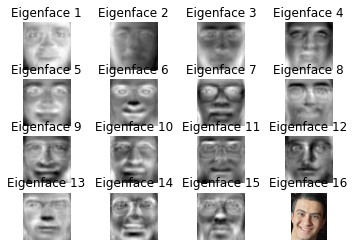

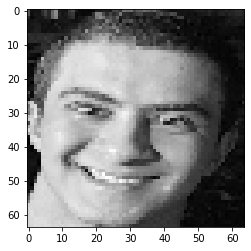

Unknown face


In [27]:
# -------------------------------- MAIN FUNCTION FOR RECOGNIZER -------------------------------- #

def recognizer_main(input_image):
    dataset = load_olivetti_dataset()
    images, _, height, width, _, _, _, _ = extract_info_from_dataset(dataset)
    omegas, eigenfaces, average_image = load_data()
    # show_eigenfaces(eigenfaces, height, width, 320)
    input_image = convert_image(input_image, width, height)

    predicted_index = predict(
        omegas, input_image, average_image, eigenfaces, height, width, 7)
    if (predicted_index == -1):
        print('Unknown face')
    else:
        print('Known face')
        # show predicted image
        plt.imshow(images[predicted_index],
                   cmap='gray', label='Predicted image')
        plt.show()
input_img = io.imread(dirname+ '/Test Images/moazTest.jpg')
recognizer_main(input_img)


In [26]:
def train():
    dataset = load_olivetti_dataset()
    images, m, height, width, total_images, n_features, y, num_people = extract_info_from_dataset(
        dataset)
    flattened_images = get_flattened_images(images, m, height, width)
    average_image = get_average_image(flattened_images, height, width)
    difference_images = get_difference_images(flattened_images, average_image)
    covariance_matrix = get_covariance_matrix(m, n_features, difference_images)
    eigenvalues, eigenfaces = eigenvalues_eigenfaces(
        covariance_matrix, difference_images)
    eigenfaces = normalize_eigenfaces(eigenfaces)
    eigenvalues, eigenfaces = sort_eigenvalues_eigenfaces(eigenvalues, eigenfaces)
    K = calculate_K(eigenvalues, m)
    eigenvalues, eigenfaces = select_K_top_eigenfaces(eigenvalues, eigenfaces, K)
    omegas = get_omegas(difference_images, eigenfaces)
    save_data_to_disk(omegas, eigenfaces, average_image)